In [1]:
# Load necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
# Chargement du dataset
file_path = r"C:\\Users\\dariu\\Desktop\\Anomaly-detection-in-Microservices-based-systems\\application anomalies dataset\\data1.csv"
df = pd.read_csv(file_path)
df['Time'] = pd.to_datetime(df['Time'], format='mixed', errors='coerce')
df.set_index('Time', inplace=True)

In [3]:
# Normalisation des features
features = df.drop(columns=["IsError"])
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)
scaled_df = pd.DataFrame(scaled_features, columns=features.columns, index=df.index)

In [4]:
# Labels
labels = df["IsError"].astype(int).values


def create_sequences(X, y, seq_length=10):
    Xs, ys = [], []
    for i in range(len(X) - seq_length):
        Xs.append(X[i:i+seq_length])
        ys.append(y[i+seq_length])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(scaled_features, labels)

In [5]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.3, random_state=42, stratify=y_seq)

In [7]:
# LSTM Model
model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(8),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [8]:
early_stop = EarlyStopping(
    monitor='val_loss',       # Surveille la validation loss
    patience=3,               # Arrête après 3 epochs sans amélioration
    restore_best_weights=True  # Restaure les meilleurs poids
)

In [9]:
# Entraînement
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.2, callbacks=[early_stop], verbose=1)

Epoch 1/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.5125 - loss: 0.6945 - val_accuracy: 0.5929 - val_loss: 0.6771
Epoch 2/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.5693 - loss: 0.6786 - val_accuracy: 0.6033 - val_loss: 0.6736
Epoch 3/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5885 - loss: 0.6732 - val_accuracy: 0.5992 - val_loss: 0.6665
Epoch 4/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5744 - loss: 0.6670 - val_accuracy: 0.5658 - val_loss: 0.6662
Epoch 5/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5698 - loss: 0.6739 - val_accuracy: 0.5992 - val_loss: 0.6560
Epoch 6/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.5649 - loss: 0.6676 - val_accuracy: 0.5887 - val_loss: 0.6385
Epoch 7/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.5893 - loss: 0.6374 - val_accuracy: 0.5971 - val_loss: 0.6328
Epoch 8/10
120/120 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6048 - loss: 0.6351 - val_accur

In [10]:
# Prédictions
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [11]:
# Métriques
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Accuracy: 0.56
Precision: 0.60
Recall: 0.37
F1-Score: 0.46


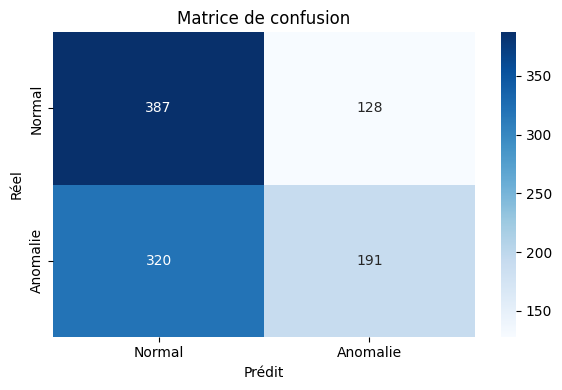

In [12]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Anomalie"],
            yticklabels=["Normal", "Anomalie"])
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.tight_layout()
plt.show()

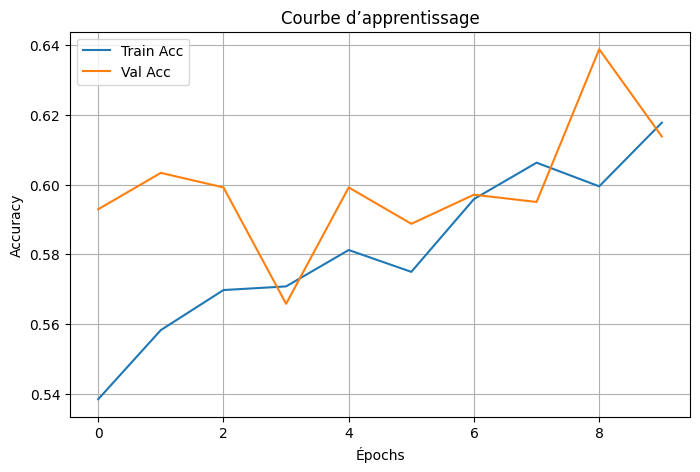

In [13]:
# Courbe d'apprentissage
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Courbe d’apprentissage")
plt.xlabel("Épochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

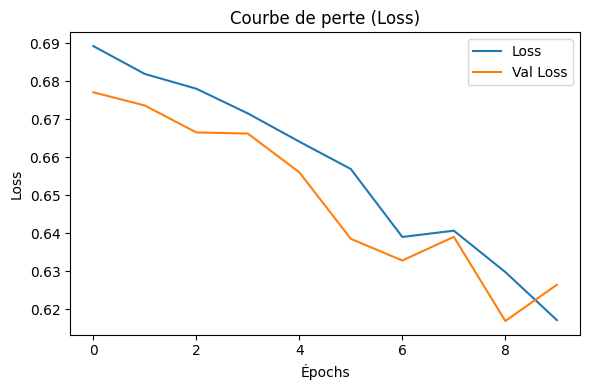

In [14]:
# Courbe de perte
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Courbe de perte (Loss)")
plt.xlabel("Épochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()